In [61]:
import math
import matplotlib.pyplot as plt
# calculus
import sympy as sym
import random
import numpy as np
import time

from scipy.special import gamma, gammaln
from mpmath import mp, gamma
mp.dps = 10  # You can set this to be high enough to handle the precision you need


In [62]:
# # sympy gamma
# def gamma_function(z):
#     t = sym.symbols('t')
#     integral = (t ** (z-1)) * sym.exp(-t)
#     lower_bound = 0
#     upper_bound = float('inf')
#     result = sym.integrate(integral, (t, lower_bound, upper_bound))
#     return result

# # scipy gamma
# def gamma_function(z):
#     gamma_result = gamma(z)

#     # Check if the result is finite
#     if np.isfinite(gamma_result):
#         return gamma_result;
#     else:
#         # Calculate the log-gamma function as an alternative
#         log_gamma_result = gammaln(z)
#         return log_gamma_result
    
    
def gamma_function(z):
    gamma_result = gamma(mp.mpf(str(z)))
    return gamma_result
#     gamma_result_str = str(gamma_190)
#     a = gamma_190 ** mp.mpf('25474533355934866200324596091092976856363582264375982528291736631431854272171653178001238618246158340591269369805242060305688413114341036961909351853298953388008415219143834097517227207323687737984459987098824288474402782737558680982050962989247645075340595655154601679542326596890748231591713616215146496000000000000000000000000000000000000000000000')

#     a

In [63]:
def getPower(n, step, scheme):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += 2 ** (i if i <= (step - 1) else (step - 1))
        return power_sum / step
    else:
        return 2 ** (n-1 if n-1 <= (step - 1) else (step - 1))

## Capture probability function

In [64]:
# def P_cap(Px, Py, CR, gamma):
#     # calculate power ratio threshold
#     Pr = 10 ** (CR / 10)
    
#     slope_1 = (Py * Pr / Px) ** (1 / gamma)
#     slope_2 = (Py / (Px * Pr)) ** (1 / gamma)

#     if slope_1 > 1 and slope_2 < 1:
#         result = (1 / ((Pr * Py / Px) ** (1 / gamma)) / 2) + (((Py / (Pr * Px)) ** (1 / gamma)) / 2)
#     elif slope_1 > 1 and slope_2 >= 1:
#         result = 1 - (1 / ((Py / (Pr * Px)) ** (1 / gamma)) - 1 / ((Pr * Py / Px) ** (1 / gamma)) ) / 2
#     elif slope_1 <= 1 and slope_2 < 1:
#         result = 1 - (((Pr * Py / Px) ** (1 / gamma)) - ((Py / (Pr * Px)) ** (1 / gamma)) ) / 2
#     return result

In [78]:
# only consider x capture
def P_cap(Px, Py, CR, gamma):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = (Py * Pr / Px) ** (1 / gamma)

    if slope_1 >= 1 :
        result = (1 / ((Pr * Py / Px)**(1 / gamma)) / 2)
    elif slope_1 <= 1:
        result = 1 - ((Pr*Py/Px)**(1 / gamma)) / 2
    return result

## Gereral analytical

In [79]:

# Lmax: Retransmit limit
# TXOP: in ms
# Imax: total slots in worst case
def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw_n [ocw_min, 1st_retry_ocw....]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
        
    Ri = [RA_RU for _ in range(0,Imax+1)]
    M  = [0 for _ in range(0,Imax+1)]
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s_C = [0 for _ in range(0,Imax+1)] # total success packet
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0

                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
            
#             counter_power += M_i_s[i][n] * 1 * n
            counter_power += M_i[i][n] * 1


        #/** performance metric */  
        #/** success probability */
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    success_probability = success_packet / sta_amount
    access_delay = (TXOP * counter_delay_slot) / success_packet
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount
    
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Random analytical (scheme 1)

In [117]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_random(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    capture_prob = 0
    for n1 in range(1, step+1):
        for n2 in range(1, step+1):
            # P is the power of two station
            P1 = 2 ** (n1 - 1)
            P2 = 2 ** (n2 - 1)
            capture_prob += P_cap(P1, P2, CR, gamma) * (1 / step) * (1 / step)

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
#             if M[i] > 0:
#                 capture_prob_n_k = 0
#                 capture_prob_n2 = 0
#                 Pn = getPower(n=n, step=step, scheme=1)
#                 capture_prob_n2 += P_cap(Pn, Pn, CR, gamma) * 2
#                 # calculate the capture prob. when n-th with k-th (K!=n)
#                 for k in range(1, Lmax+1):
#                     Pk = getPower(n=k, step=step, scheme=1)
#                     if (n != k):
#                         if (M[i] > M_i[i][n]):
#                             capture_prob_n_k += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
            # 0.7079457843841379 0.7739634835364259
            if (M[i] >= 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] += 0.7739634835364259 * (M_i[i][n] / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += (capture_prob * 2) * ((M_i[i][n] / M[i]) ** 2) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += (capture_prob * 2) * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] += capture_prob_n2 * ((M_i[i][n] / M[i]) ** 2) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] += capture_prob_n_k * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
            if (M[i] < 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])

            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=step, scheme=1) * M_i[i][n]
            
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Transmit-based analytical (scheme 2)

In [118]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_rampup(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            

        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            if M[i] > 0:
                capture_prob_n_k = 0
                capture_prob_n2 = 0
                Pn = getPower(n=n, step=step, scheme=2)
                capture_prob_n2 += P_cap(Pn, Pn, CR, gamma) * 2
                # calculate the capture prob. when n-th with k-th (K!=n)
                for k in range(1, Lmax+1):
                    Pk = getPower(n=k, step=step, scheme=2)
                    if (n != k):
                        if (M[i] > M_i[i][n]):
#                             capture_prob_n_k += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
                            capture_prob_n_k += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
            
            if (M[i] >= 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n2 * ((M_i[i][n] / M[i]) ** 2) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n_k * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
            if (M[i] < 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])

            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=step, scheme=2) * M_i[i][n]
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

# Scenario I
Scenario III was designed to investigate the impact of transmit power levels $N$ on access success probability.

- Figure: $P_s$ for [$N=1$, $N=2$, $N=3$]
- Parameters: $R=128, C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$
- x-axis: M STAs (10-200)

In [119]:
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
CR = 3
N = 4
T_slot = 5.673

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

In [120]:
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

### Genral simu result

In [121]:
ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99998, 0.9951550000000033, 0.8032966666666674, 0.4294125000000001, 0.20330399999999887, 0.09681833333333335, 0.04672571428571417, 0.023302499999999914, 0.011384444444444412, 0.005897999999999952]
da_list_simu_148 = [5.672999999999856, 5.735402999999855, 5.7599859999998575, 5.777950499999862, 5.8318439999998715, 5.850753999999871, 5.9104555714284315, 5.9396309999998955, 5.962322999999897, 6.033235499999913, 6.362269500000021, 6.740280399999999, 7.069550775000024, 7.4488759200000185, 7.778628500000003, 8.19521580000001, 8.513542012500055, 8.915812866666665, 9.299273062653057, 14.04194140099018, 17.836764838499256, 18.375816964324926, 18.028541577693446, 17.704704584891253, 17.473260247105767, 17.206154234582453, 17.269189892541746, 17.006939963311723]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.999599999999997, 39.80619999999981, 48.19779999999998, 34.35299999999999, 20.33039999999999, 11.618200000000007, 6.541599999999995, 3.7284000000000015, 2.049200000000002, 1.1795999999999975]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513243243243023, 0.26896081081080797, 0.32566081081081066, 0.23211486486486468, 0.13736756756756752, 0.07850135135135124, 0.044199999999999996, 0.025191891891891884, 0.013845945945946011, 0.007970270270270292]
power_list_simu_148 = [1.0, 1.011, 1.015333333333333, 1.0185, 1.027999999999999, 1.0313333333333343, 1.0418571428571455, 1.047, 1.0509999999999955, 1.0635000000000048, 1.1215000000000057, 1.1881333333333393, 1.2461750000000027, 1.313040000000002, 1.371166666666665, 1.4446000000000008, 1.5007125000000021, 1.571622222222224, 1.639318163265307, 2.4998915645223327, 4.384967877674983, 9.953864039782061, 23.004565477644185, 50.63815431181972, 108.58008540833075, 225.05152064799915, 492.6347755443622, 1028.6076920940166]

### random simu result

In [122]:
ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99998, 0.9924733333333389, 0.8487600000000002, 0.5310859999999997, 0.2825849999999996, 0.14641428571428583, 0.07648999999999992, 0.04086222222222211, 0.021816999999999875]
da_list_simu_148_random = [5.672999999999856, 5.707037999999859, 5.722165999999858, 5.753840249999868, 5.778517799999868, 5.777004999999861, 5.800237285714163, 5.850281249999896, 5.851384333333213, 5.882333699999912, 6.113792099999989, 6.341657599999999, 6.580538175000027, 6.7963674600000195, 7.0335745, 7.264276499999987, 7.499776912500027, 7.735576733333342, 8.00216361, 10.861186845376908, 14.637487449330042, 17.813273711894883, 18.61362839496671, 18.377387400377035, 17.986190382588088, 17.627772057257783, 17.408961377724268, 17.288458454953137]
t_list_simu_148_random = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.999199999999995, 59.54840000000008, 67.90079999999998, 53.10860000000003, 33.910199999999996, 20.498000000000005, 12.238399999999997, 7.3552, 4.363399999999999]
u_list_simu_148_random = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.27026486486486045, 0.4023540540540527, 0.4587891891891895, 0.3588418918918916, 0.2291229729729725, 0.13849999999999996, 0.08269189189189188, 0.04969729729729727, 0.02948243243243243]
power_list_simu_148_random = [3.836, 3.7555, 3.73466666666667, 3.7545, 3.853599999999997, 3.766333333333332, 3.825142857142857, 3.898, 3.8989999999999996, 3.820799999999995, 4.003300000000007, 4.212699999999998, 4.347775000000001, 4.485960000000008, 4.6639166666666725, 4.778414285714284, 4.956499999999996, 5.103955555555551, 5.286999999999995, 7.182969572864312, 9.81597687846505, 15.136305257180453, 28.99971616578783, 60.09368490970449, 122.28717066723723, 241.9800726057197, 463.5542621258943, 894.3071301091985]

### Ramp Up simu result

In [123]:
ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999250000000001, 0.9836000000000094, 0.8072000000000004, 0.49176000000000014, 0.26192333333333323, 0.13690285714285724, 0.0720174999999999, 0.037878888888888754, 0.02004399999999996]
da_list_simu_148_ramp = [5.672999999999856, 5.707037999999858, 5.741075999999861, 5.760931499999865, 5.768306399999874, 5.831843999999864, 5.836706571428452, 5.841062624999891, 5.873445999999886, 5.893679699999908, 6.135633149999992, 6.389499899999996, 6.641381100000007, 6.868528020000008, 7.081416800000003, 7.346697085714284, 7.563314512500038, 7.840022966666686, 8.089641270000001, 11.119914912350392, 15.044584425810541, 17.8309273140894, 18.477843021180238, 18.24471920566436, 17.87782405084548, 17.61301112437577, 17.442956022708753, 17.237752370446458]
t_list_simu_148_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.99699999999999, 59.015999999999835, 64.57600000000004, 49.17599999999998, 31.43080000000006, 19.166399999999978, 11.522800000000004, 6.8182000000000045, 4.008799999999995]
u_list_simu_148_ramp = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2702499999999956, 0.39875675675675537, 0.4363243243243248, 0.3322702702702703, 0.21237027027027008, 0.1295027027027027, 0.07785675675675667, 0.04606891891891889, 0.027086486486486438]
power_list_simu_148_ramp = [1.0, 1.012, 1.0239999999999998, 1.032, 1.0335999999999985, 1.0566666666666678, 1.0577142857142878, 1.05925, 1.0706666666666633, 1.0780000000000027, 1.1643000000000032, 1.2577333333333396, 1.352899999999998, 1.4410799999999997, 1.526633333333331, 1.637485714285712, 1.732374999999999, 1.8596888888888896, 1.97708, 3.8954630308106193, 7.90118363046208, 16.058394220429395, 35.204089610333405, 76.40079708549163, 157.24517859397167, 311.6957061993682, 611.1789483474196, 1196.778014788426]

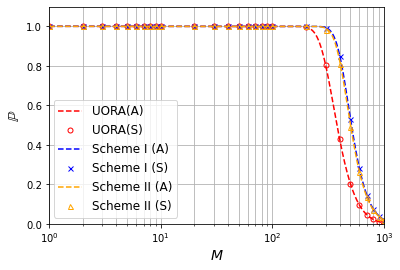

In [170]:
# print(ps_list[4])
# general
plt.semilogx(m_list, ps_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, ps_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, ps_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, ps_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, ps_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R=148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{P}$", fontsize = 15)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.3), fontsize = 12)
plt.axis([1,sta_max,0.0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

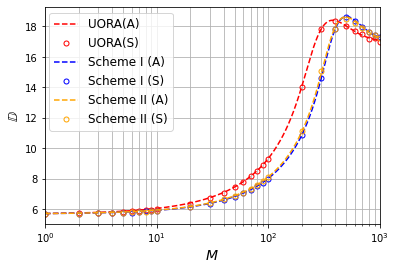

In [169]:
# general
plt.semilogx(m_list, da_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, da_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, da_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, da_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, da_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{D}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.xlim(1, sta_max)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

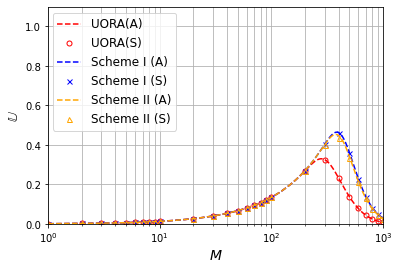

In [168]:
# print(ps_list[4])
# general
plt.semilogx(m_list, u_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, u_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, u_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, u_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping 
plt.semilogx(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, u_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

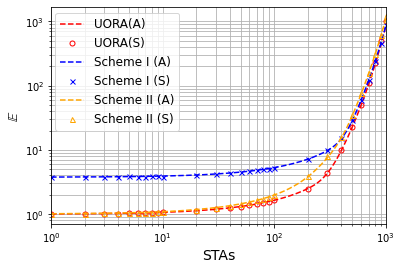

In [167]:
# print(ps_list[4])
# general
plt.plot(m_list, power_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.plot(m_list_simu, power_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.plot(m_list, power_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.plot(m_list_simu, power_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.plot(m_list_simu, power_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# Scenario II ($R$ ---> $E$)
Scenario II was designed to investigate the impact of different numbers of RA-RU on power efficiency.

- Figure: $E$ for [$R=9$, $R=18$, $R=37$, $R=74$]
- Parameters: $C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$, $N=4$
- x-axis: M STAs (10-200)

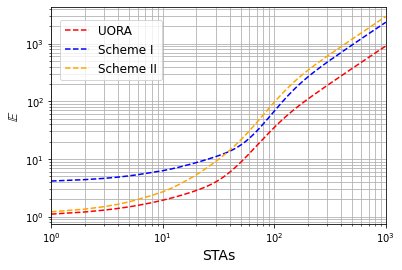

intersect at M=38


In [180]:
# R=9
# general
plt.plot(m_list, power_list[0], linestyle = '--', color='red', label='UORA')

# random
plt.plot(m_list, power_list_random[0], linestyle = '--', color='blue', label='Scheme I')
# ramping
plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='orange', label='Scheme II')

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.35, 0.8), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if power_list_ramp[0][i] > power_list_random[0][i]:
        print(f'intersect at M={i+1}')
        break

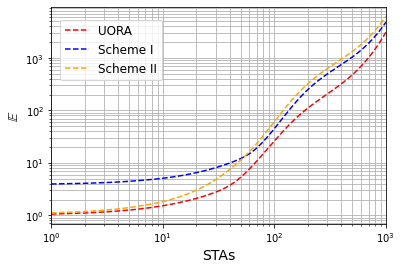

intersect at M=55


In [182]:
# R=18
# general
plt.plot(m_list, power_list[1], linestyle = '--', color='red', label='UORA')

# random
plt.plot(m_list, power_list_random[1], linestyle = '--', color='blue', label='Scheme I')
# ramping
plt.plot(m_list, power_list_ramp[1], linestyle = '--', color='orange', label='Scheme II')

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.35, 0.8), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if power_list_ramp[1][i] > power_list_random[1][i]:
        print(f'intersect at M={i+1}')
        break

# Scenario II ($R$ ---> $\mathbb{P}$)
Scenario II was designed to investigate the impact of different numbers of RA-RU on power efficiency.

- Figure: $\mathbb{P}$ for [$R=9$, $R=18$, $R=37$, $R=74$]
- Parameters: $C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$, $N=4$
- x-axis: M STAs (10-200)

In [195]:
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
# ocw_max = 127
CR = 3
N = 4
T_slot = 5.673

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

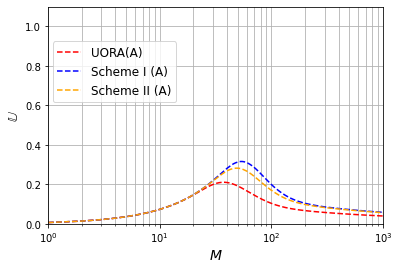

intersect at M=38
intersect at M=161


In [208]:
# U=9
index = 0
# general
plt.semilogx(m_list, u_list[index], linestyle = '--', color='red', label='UORA(A)')

# random
plt.semilogx(m_list, u_list_random[index], linestyle = '--', color='blue', label='Scheme I (A)')
# ramping 
plt.semilogx(m_list, u_list_ramp[index], linestyle = '--', color='orange', label='Scheme II (A)')

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# for i in range(1000):
#     if (u_list_ramp[index][i] - u_list[index][i]) > 0.01:
#         print(f'intersect at M={i+1}')
#         break

for i in range(1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) > 0.01:
        print(f'intersect at M={i+1}')
        break
        
for i in range(38, 1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) < 0.01:
        print(f'intersect at M={i+1}')
        break

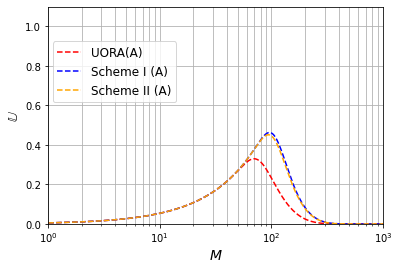

intersect at M=60
intersect at M=288


In [214]:
# U=37
index = 2
# general
plt.semilogx(m_list, u_list[index], linestyle = '--', color='red', label='UORA(A)')

# random
plt.semilogx(m_list, u_list_random[index], linestyle = '--', color='blue', label='Scheme I (A)')
# ramping 
plt.semilogx(m_list, u_list_ramp[index], linestyle = '--', color='orange', label='Scheme II (A)')

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if (u_list_random[index][i] - u_list[index][i]) > 0.01:
        print(f'intersect at M={i+1}')
        break

for i in range(60, 1000):
    if (u_list_random[index][i] - u_list[index][i]) < 0.01:
        print(f'intersect at M={i+1}')
        break
# for i in range(93, 1000):
#     if (u_list_random[index][i] - u_list_ramp[index][i]) < 0.01:
#         print(f'intersect at M={i+1}')
#         break

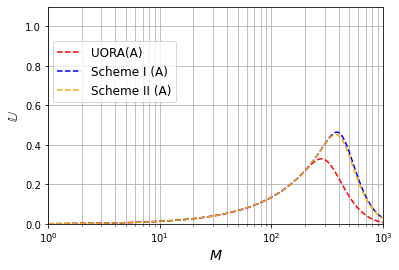

intersect at M=372
intersect at M=679


In [219]:
# U=37
index = 4
# general
plt.semilogx(m_list, u_list[index], linestyle = '--', color='red', label='UORA(A)')

# random
plt.semilogx(m_list, u_list_random[index], linestyle = '--', color='blue', label='Scheme I (A)')
# ramping 
plt.semilogx(m_list, u_list_ramp[index], linestyle = '--', color='orange', label='Scheme II (A)')

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# for i in range(1000):
#     if (u_list_random[index][i] - u_list[index][i]) > 0.01:
#         print(f'intersect at M={i+1}')
#         break

# for i in range(60, 1000):
#     if (u_list_random[index][i] - u_list[index][i]) < 0.01:
#         print(f'intersect at M={i+1}')
#         break
for i in range(0, 1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) > 0.01:
        print(f'intersect at M={i+1}')
        break
        
for i in range(678, 1000):
    if (u_list_random[index][i] - u_list_ramp[index][i]) < 0.01:
        print(f'intersect at M={i+1}')
        break

### Scenario III ($C$ ---> $E$)
Scenario III was designed to investigate the impact of capture threshold $C$ on power efficiency.

- Figure: $E$ for [$C=1.5$ dB, $C=6$ dB]
- Parameters: $R=128, L_{max}=5, OCW_{min}=7, OCW_{max}=31$
- x-axis: M STAs (1-200)

In [224]:
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
# ocw_max = 127
CR = 3
N = 2
T_slot = 5.673

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

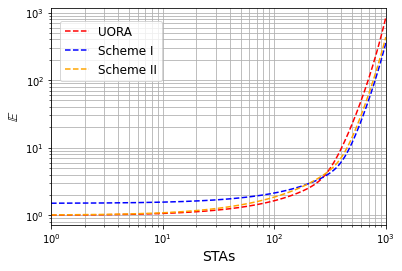

intersect at M=300


In [235]:
# R=9
index = 4
# general
plt.plot(m_list, power_list[index], linestyle = '--', color='red', label='UORA')

# random
plt.plot(m_list, power_list_random[index], linestyle = '--', color='blue', label='Scheme I')
# ramping
plt.plot(m_list, power_list_ramp[index], linestyle = '--', color='orange', label='Scheme II')

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.35, 0.8), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

for i in range(1000):
    if (power_list_random[index][i] < power_list[index][i]) and (power_list_ramp[index][i] < power_list[index][i]):
        print(f'intersect at M={i+1}')
        break
